In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="7"
os.environ["TFHUB_CACHE_DIR"]="tfhub_modules"

import tensorflow as tf
from keras import backend as K
print(tf.__version__)
print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


1.10.0
['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow_hub as hub
from keras.utils import to_categorical
from keras.engine import Layer
import keras.layers as layers
from keras.layers import Input, Lambda, Dense, Dropout
from keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import logging


logging.basicConfig(level=logging.DEBUG, format='%(name)s - %(levelname)s - %(message)s')

# Initialize session
sess = tf.Session()
K.set_session(sess)

matplotlib.backends - DEBUG - backend module://ipykernel.pylab.backend_inline version unknown


In [3]:
from numpy.random import seed
from tensorflow import set_random_seed

RANDOM_SEED = 20190101

def set_random(random_seed):
    seed(random_seed)
    set_random_seed(random_seed)

set_random(RANDOM_SEED)

In [4]:
class ISEARDataset(object):
  FILENAME = "data/isear_databank.csv"
  EMOTION_CLASSES = ["anger", "disgust", "fear", "guilt", "joy", "sadness", "shame"]
  EMOTION_CLASSES_DICT = {"anger": 0, "disgust": 1, "fear": 2, "guilt": 3, "joy": 4, "sadness": 5, "shame": 6}
  RANDOM_STATE = 41
  
  def get_classes(self):
    return self.EMOTION_CLASSES
  
  def get_classes_dict(self):
    return self.EMOTION_CLASSES_DICT
  
  def __load_data_file(self):
    data = pd.read_csv(self.FILENAME)
    data["emotion"] = data["Field1"]
    data["text"] = data["SIT"]
    return data[["text", "emotion"]]

  def load_data(self):
    train_data = None
    test_data = None
    
    data = self.__load_data_file()
    
    train_data, test_data = train_test_split(data, test_size=0.3, random_state=self.RANDOM_STATE, stratify=data["emotion"].values)
    return train_data, test_data

In [5]:
isear_dataset = ISEARDataset()
train_data, test_data = isear_dataset.load_data()
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=200, stratify=train_data.emotion)

logging.debug("train_data.shape: (%d, %d)" % train_data.shape)
logging.debug("valid_data.shape: (%d, %d)" % valid_data.shape)
logging.debug("test_data.shape: (%d, %d)" % test_data.shape)

root - DEBUG - train_data.shape: (4829, 2)
root - DEBUG - valid_data.shape: (537, 2)
root - DEBUG - test_data.shape: (2300, 2)


root - DEBUG - class dictionary: {'anger': 0, 'disgust': 1, 'fear': 2, 'guilt': 3, 'joy': 4, 'sadness': 5, 'shame': 6}
root - DEBUG - class labels: ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']
root - DEBUG - number of bins: 7
matplotlib.font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
matplotlib.font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


bins: [0, 1, 2, 3, 4, 5, 6, 7]


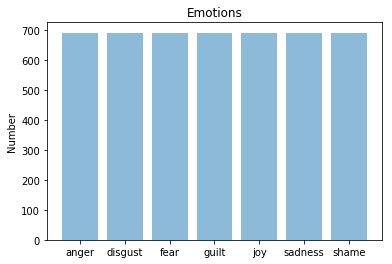

In [6]:
dic = isear_dataset.get_classes_dict()
labels = isear_dataset.get_classes()
n_classes = len(labels)
logging.debug("class dictionary: %s" % dic)
logging.debug("class labels: %s" % labels)
logging.debug("number of bins: %s" % n_classes)

for emotion in labels:
  train_data.loc[train_data.emotion == emotion, "emotion_int"] = dic[emotion]
  valid_data.loc[valid_data.emotion == emotion, "emotion_int"] = dic[emotion]
  test_data.loc[test_data.emotion == emotion, "emotion_int"] = dic[emotion]

bins = list(range(0, n_classes + 1))
print("bins:", bins)
hist, _ = np.histogram(train_data["emotion_int"], bins=bins)

y_pos = np.arange(len(labels))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

In [7]:
X_train = np.array(train_data.text, dtype=object)[:, np.newaxis]
X_val = np.array(valid_data.text, dtype=object)[:, np.newaxis]
X_test = np.array(test_data.text, dtype=object)[:, np.newaxis]

y_train = to_categorical(np.asarray(train_data.emotion.apply(lambda x:dic[x])))
y_val = to_categorical(np.asarray(valid_data.emotion.apply(lambda x:dic[x])))
y_test = to_categorical(np.asarray(test_data.emotion.apply(lambda x:dic[x])))

logging.debug('Shape of X train, validation and test tensor: %s, %s, %s' % (X_train.shape, X_val.shape, X_test.shape))
logging.debug('Shape of label train, validation and test tensor: %s, %s, %s' % (y_train.shape, y_val.shape, y_test.shape))

root - DEBUG - Shape of X train, validation and test tensor: (4829, 1), (537, 1), (2300, 1)
root - DEBUG - Shape of label train, validation and test tensor: (4829, 7), (537, 7), (2300, 7)


In [8]:
def ELMoEmbedding(x):
    url = "https://tfhub.dev/google/elmo/2"
    embed = hub.Module(url)
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [9]:
# Function to build model
def build_model(drop_rate=0.2):
    input_text = layers.Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
    dense = Dense(256, activation='relu')(embedding)
    dropout = Dropout(drop_rate)(dense)
    pred = Dense(n_classes, activation='softmax')(dropout)
    model = Model(inputs=[input_text], outputs=pred)
    model.summary()

    return model

In [10]:
import datetime
from keras.optimizers import Adam, Adadelta, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint


start_time = datetime.datetime.now()

# Build and fit
model = build_model()

INFO:tensorflow:Using tfhub_modules to cache modules.


tensorflow - INFO - Using tfhub_modules to cache modules.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


tensorflow - INFO - Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 1799      
Total params: 264,199
Trainable params: 264,199
Non-trainable params: 0
_________________________________________________________________


In [11]:
adam = Adam(lr=1e-3, decay=0.0)
adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

filepath="tmp/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
callbacks = [early_stopping, model_checkpoint]

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    batch_size=32, 
    epochs=100, 
    verbose=1, 
    validation_data=(X_val, y_val), 
    callbacks=callbacks
)  # starts training

end_time = datetime.datetime.now()

def days_hours_minutes_seconds(td):
    return td.days, td.seconds//3600, (td.seconds//60)%60, (td.seconds%60)

elapsed_time = end_time - start_time
logging.debug("%d days, %d hours, %d minutes, %d seconds elapsed" % (days_hours_minutes_seconds(elapsed_time)))

Train on 4829 samples, validate on 537 samples
Epoch 1/100
4829/4829 [==============================] - 51s 10ms/step - loss: 1.6985 - acc: 0.3541 - val_loss: 1.5052 - val_acc: 0.4488

Epoch 00001: val_acc improved from -inf to 0.44879, saving model to tmp/weights-01-0.45.hdf5
Epoch 2/100
4829/4829 [==============================] - 43s 9ms/step - loss: 1.4380 - acc: 0.4663 - val_loss: 1.4675 - val_acc: 0.4469

Epoch 00002: val_acc did not improve from 0.44879
Epoch 3/100
4829/4829 [==============================] - 43s 9ms/step - loss: 1.3392 - acc: 0.5140 - val_loss: 1.3856 - val_acc: 0.4953

Epoch 00003: val_acc improved from 0.44879 to 0.49534, saving model to tmp/weights-03-0.50.hdf5
Epoch 4/100
4829/4829 [==============================] - 42s 9ms/step - loss: 1.2529 - acc: 0.5415 - val_loss: 1.3942 - val_acc: 0.4823

Epoch 00004: val_acc did not improve from 0.49534
Epoch 5/100
4829/4829 [==============================] - 41s 8ms/step - loss: 1.2045 - acc: 0.5678 - val_loss: 1.30

root - DEBUG - 0 days, 0 hours, 11 minutes, 55 seconds elapsed



Epoch 00017: val_acc did not improve from 0.55307


In [12]:
model.save('isear_dense_elmo_model.h5')
model.save_weights('isear_dense_elmo_weights.h5')

logging.debug("model and weights is successfully saved")

root - DEBUG - model and weights is successfully saved


## Evaluate the model

In [13]:
y_pred = model.predict(X_test)

y_pred_original = [labels[val] for val in np.argmax(y_pred, axis=1).squeeze()]
y_test_original = np.asarray(test_data.emotion)

In [14]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=15):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [15]:
cf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=labels)

df_cm = pd.DataFrame(
    cf_matrix, index=labels, columns=labels, 
)

df_cm

,anger,disgust,fear,guilt,joy,sadness,shame
anger,140,40,13,58,29,16,33
disgust,60,172,21,32,15,8,21
fear,21,23,199,31,16,19,19
guilt,52,12,16,192,13,12,31
joy,9,5,9,17,269,8,11
sadness,29,16,22,41,49,158,14
shame,39,28,13,106,25,11,107


matplotlib.font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.0 to DejaVu Sans ('/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


Figure(288x216)


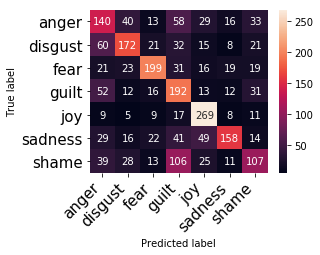

In [16]:
print(print_confusion_matrix(cf_matrix, class_names=labels))

In [17]:
test_accuracy = accuracy_score(y_test_original, y_pred_original)
print("test accuracy:", test_accuracy)

test accuracy: 0.5378260869565218


### Performance score for each classes

In [18]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support.round(4)
}
score_df = pd.DataFrame(score_dict, index=labels)
score_df

,precision,recall,f1-score,support
anger,0.4000,0.4255,0.4124,329
disgust,0.5811,0.5228,0.5504,329
fear,0.6792,0.6067,0.6409,328
guilt,0.4025,0.5854,0.4770,328
joy,0.6466,0.8201,0.7231,328
sadness,0.6810,0.4802,0.5633,329
shame,0.4534,0.3252,0.3788,329


### Performance score using micro average

In [19]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="micro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,precision,recall,f1-score,support
score,0.5378,0.5378,0.5378,None


### Performance score using macro average

In [20]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="macro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,precision,recall,f1-score,support
score,0.5491,0.538,0.5351,None


### Performance score using weighted average

In [21]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="weighted")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,precision,recall,f1-score,support
score,0.5491,0.5378,0.535,None


### Cohen Kappa Score

In [22]:
from sklearn.metrics import cohen_kappa_score

kappa_score = cohen_kappa_score(y_test_original, y_pred_original, labels=labels)
print("kappa:", kappa_score)

kappa: 0.4608209177401804
